<a href="https://colab.research.google.com/github/rudeboybert/SDS390/blob/master/PS/PS02_albert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 03

Instructions:
1. Name: Charavee Basnet Chettri
1. Create a new ChatGPT chat called "SDS390 PS03" that contains all the prompts you used for this problem set. **After you've completed your assignment**, click the share button and paste the URL in Markdown format [here](https://chat.openai.com/share/f25737b9-35b4-42dc-b36e-49f0e5dcb3fc) (shared ChatGPT links don't auto-update with subsequent queries).

Overview of this PS: You will be recreating graphs and explicitly computing values from "FPP 5 - The forecaster's toolbox" in python. Specifically

1. FPP 5.2 - Some simple forecasting methods: Recreate Fig 5.7 
2. FPP 5.4 - Residual diagnostics: Recreate the 3 components of Fig 5.13
3. FPP 5.8 - Evaluating point forecast accuracy: Recompute 4 RMSE values in table using data wrangling
4. ~~FPP 5.7 - Forecasting with decomposition: Recreate Fig 5.19 by computing all values using data wrangling~~

Overall instructions:

- Do not use a function from a specialized time series forecasting specific python library to do this PS. Rather use pandas data wrangling, matplotlib, or any other package we've used to date (like for autocorrelation functions)
- Depending on your data wrangling approach for the questions below, you *may* get a warning that says "A value is trying to be set on a copy of a slice from a DataFrame." As long as your values are correct, you may ignore this warning
- Using the lessons you learned in the 3rd DataCamp on Data Viz, Chapters 1 and 2:
    - Give all your plots titles
    - Label all axes
    - Make any other cosmetic changes you like


In [205]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

import math

import statsmodels.api as sm
from pylab import rcParams

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

import numpy as np

# Load and explore data

In [325]:
aus_production = pd.read_csv("PS03_aus_production.csv", parse_dates = ['Quarter'], index_col = 'Quarter')
# aus_production = aus_production.to_period('Q')
print(aus_production.head())
print("\n")
print(aus_production.tail())

            Beer
Quarter         
1992-01-01   443
1992-04-01   410
1992-07-01   420
1992-10-01   532
1993-01-01   433


            Beer
Quarter         
2009-04-01   398
2009-07-01   419
2009-10-01   488
2010-01-01   414
2010-04-01   374


# FPP 5.2: Recreate Fig 5.7

- Recall from Lec 7.2 this requires training (1992 Q1 - 2006 Q4) vs test set (2007 Q1 - 2010 Q2) splitting of data

In [326]:
#creating Train and Test set 
train_main = aus_production.loc['1992-01-01':'2006-10-01']
test_main = aus_production.loc['2007-01-01':'2010-04-01']

#solving: “A value is trying to be set on a copy of a slice from a DataFrame"
pd.options.mode.chained_assignment = None

In [327]:
train = train_main.copy()
test = test_main.copy()

In [328]:
#mean method 
print(train.mean())
test['Mean']= 436.45

Beer    436.45
dtype: float64


In [329]:
#naive method
print(train.tail(1))
test['Naive']= 491
test

            Beer
Quarter         
2006-10-01   491


,Beer,Mean,Naive
Quarter,,,
2007-01-01,427,436.45,491
2007-04-01,383,436.45,491
2007-07-01,394,436.45,491
2007-10-01,473,436.45,491
2008-01-01,420,436.45,491
2008-04-01,390,436.45,491
2008-07-01,410,436.45,491
2008-10-01,488,436.45,491
2009-01-01,415,436.45,491


In [330]:
#this is a function that when called performs the seasonal naive method; citation in the Sources.
#The explanation what each line does given by myself.

def pysnaive(train_series,seasonal_periods,forecast_horizon):
        
        last_season=train_series.iloc[-seasonal_periods:]
        #This line extracts the last 4 elements from the train set. 
        #This represents the last observed season in the training data
        
        reps=int(np.ceil(forecast_horizon/seasonal_periods)) 
        #This line calculates number of repetitions (`reps`) needed to cover the entire forecast horizon. 
        #The np.ceil function ensures that even if the division doesn't result in an exact integer, 
        #it is rounded up to the nearest integer
        
        fcarray=np.tile(last_season,reps)
        #Use np.tile to repeat the last season array (last_season) `reps` times, 
        #creating an array (fcarray) that covers the entire forecast horizon
        
        fcast=pd.Series(fcarray[:forecast_horizon])
        #Create a pandas Series (fcast) by taking the first `forecast_horizon` elements from the repeated array. 
        #This represents the forecasted values
             
        return fcast

In [331]:
#calling the above defined function
snaive = pysnaive(train["Beer"], 
                seasonal_periods=4,
                forecast_horizon=14)

#mutating to the test dataset 
test["Seasonal Naive"] = snaive.values 

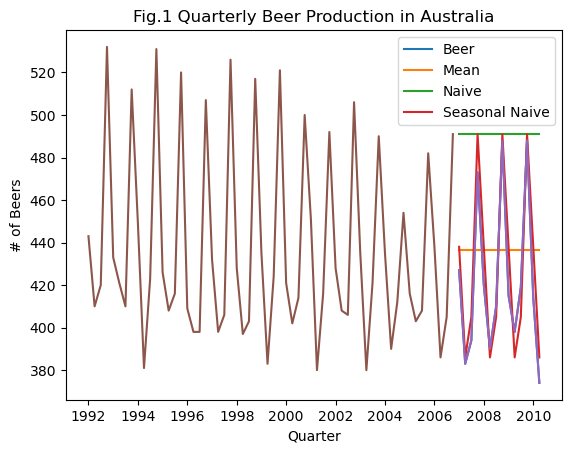

In [332]:
plt.plot(test)
plt.plot(test['Beer'])
plt.legend(test,loc='upper right')
plt.plot(train)
plt.title('Fig.1 Quarterly Beer Production in Australia')
plt.xlabel('Quarter')
plt.ylabel('# of Beers')
plt.show()

# FPP 5.4 - Residual diagnostics: Recreate the 3 components of Fig 5.13

- Compute the three residuals diagnostics plot in Fig 5.13 for the naive method forecasts
- Do this for the training data in the Beer data above. This is because when doing a residual diagnostic of a model, you want to compare observed values $y_t$ and fitted / predicted / forecasted values $\hat{y}_t$ for the data you used to fit the model.
- It's already obvious that there are much better choices than the naive method for forecasting. For each of the three residual diagnostics plots:
    - Comment on the residuals pattern you observe
    - Explain why the pattern you observe is consistent with the fact that there are much better choices than the naive method for forecasting


In [333]:
resid = test_main.copy()
resid['Beer_hat'] = 491
resid['Residual'] = resid['Beer'].sub(resid['Beer_hat'])
resid_reset = resid.reset_index()

In [341]:
resid_reset

,Quarter,Beer,Beer_hat,Residual
0,2007-01-01,427,491,-64
1,2007-04-01,383,491,-108
2,2007-07-01,394,491,-97
3,2007-10-01,473,491,-18
4,2008-01-01,420,491,-71
5,2008-04-01,390,491,-101
6,2008-07-01,410,491,-81
7,2008-10-01,488,491,-3
8,2009-01-01,415,491,-76
9,2009-04-01,398,491,-93


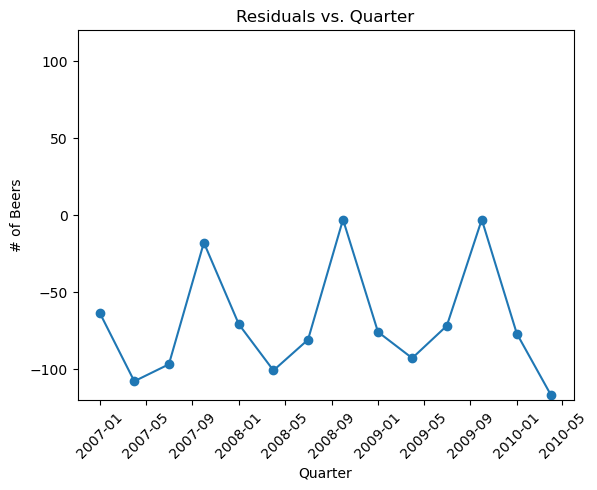

In [334]:
#residuals v. quarter
plt.plot(resid_reset['Quarter'], resid_reset['Residual'], marker='o', linestyle='-')
plt.title('Residuals vs. Quarter')
plt.xlabel('Quarter')
plt.ylabel('# of Beers')
plt.ylim(-120, 120)
plt.xticks(rotation=45)
plt.show()

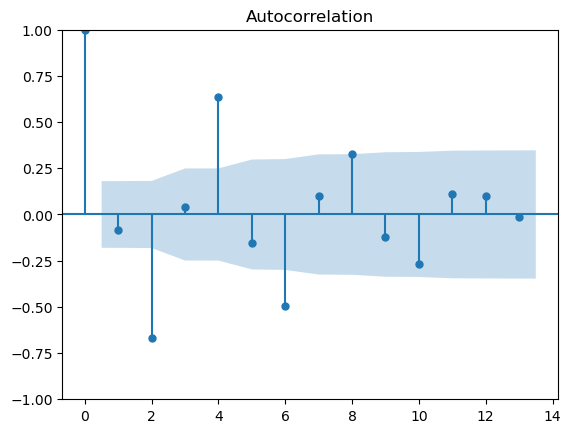

In [335]:
#residual autocorrelation plot
plot_acf(resid_reset['Residual'], alpha=0.5, lags=13)
plt.show()

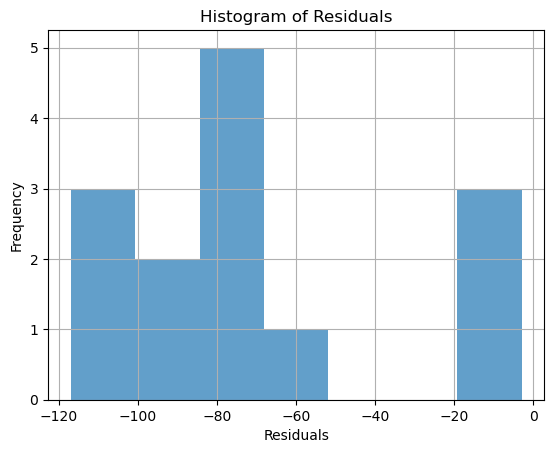

In [336]:
#histogram of residuals
resid_reset['Residual'].hist(bins=7, alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

### Observation + Explanation

The results of residual diagnostics show that there may be better choices than the naive method of forecasting. 

In the first plot, we observe that the residuals range from -117 to -3. This observation shows that the naive method does not account for all the trend signals of the data. As seen in the first plot and the histogram, most of the residuals are negative, which means that the naive method overestimates. It is intuitive given how the method forecasts 491 for dips in beer production. 

In the second plot, we observe that residuals are correlated with the past lagged values of the residuals. We know that the autocorrelation with lag zero always equals 1 because this represents the autocorrelation between the term and itself. As discussed in class, it is important to note that there are not enough data points for residual analysis. With the available information, this autocorrelation plot suggests that the residuals do not follow a random pattern. Firstly, we observe a positive autocorrelation between the residual from the 4th quarter with seasonality every 4 quarters. Interestingly, Australia experiences the summer around this quarter. Secondly, we observe a negative correlation between the residual from the 2nd quarter with seasonality every 4 quarters from that point onwards. Interestingly again, we observe that the 2nd quarter sees the biggest decreases in beer production since this is around the fall. This repetitive up-and-down component displays seasonality the forecasting method does not capture. 

In the thrid plot, we observe that the residuals do not follow a normal distribution. Therefore, the prediction intervals from the naive forecast will be inaccurate which does not capture all of the potential values that Beer production may take. 

Even visually in the Fig 1, we observe that the naive forecast of 491, does not capture the seasonality (or the highs and lows) associated with the beer production. 

# FPP 5.8 - Evaluating point forecast accuracy: Recompute RMSE and MAE values in table using data wrangling

For the three forecasting methods above, compute the:

- Root mean squared error
- Mean absolute error

which gives a single numerical measure of the overall error of the model. 

Note that the table in FPP 5.8 uses a slightly different training set 1992 Q1 - 2007 Q4, instead of 1992 Q1 - 2006 Q4, so you will get slightly different error values, but they should still be close.

In [337]:
test['res_mean']= test['Beer'].sub(test['Mean'])
test['res_naive']= test['Beer'].sub(test['Naive'])
test['res_snaive']= test ['Beer'].sub(test['Seasonal Naive'])

In [338]:
#Calculating the MAE for each method
mae_mean = round(test['res_mean'].abs().mean(),2)
mae_naive = round (test['res_naive'].abs().mean(),2)
mae_snaive = round (test['res_snaive'].abs().mean(),2)

#Calculating the RMSE for each method
rmse_mean = round (math.sqrt(pow(test['res_mean'],2).mean()),2)
rmse_naive = round (math.sqrt(pow(test['res_naive'],2).mean()),2)
rmse_snaive = round (math.sqrt(pow(test['res_snaive'],2).mean()),2)

table = {
    'Method': ['Mean', 'Naive', 'Seasonal Naive'],
    'RMSE': [rmse_mean, rmse_naive, rmse_snaive],
    'MAE': [mae_mean, mae_naive, mae_snaive]
}

table = pd.DataFrame(table)

table

,Method,RMSE,MAE
0,Mean,38.89,35.47
1,Naive,78.62,70.07
2,Seasonal Naive,13.49,11.50


Since RMSE and MAE of the Seasonal Naive forecasting method are the lowest relative to the other methods, we can conclude that the Seasonal Naive method will deliver the highest accuracy compared to the other methods.

# Sources 

1. Seasonal Naive Method Function https://pawarbi.github.io/blog/forecasting/r/python/rpy2/altair/fbprophet/ensemble_forecast/uncertainty/simulation/2020/04/21/timeseries-part2.html#Seasonal-Naive-Forecast-model

2. RMSE Calculation https://www.javatpoint.com/rsme-root-mean-square-error-in-python 

3. MAE Calculation https://www.geeksforgeeks.org/how-to-calculate-mean-absolute-error-in-python/ 


# Appendix

In [ ]:
# #this is a function that when called performs the seasonal naive method
# def pysnaive(train_series,seasonal_periods,forecast_horizon):
#     '''
#     Python implementation of Seasonal Naive Forecast. 
#     This should work similar to https://otexts.com/fpp2/simple-methods.html
#     Returns two arrays
#      > fitted: Values fitted to the training dataset
#      > fcast: seasonal naive forecast
    
#     Author: Sandeep Pawar
    
#     Date: Apr 9, 2020
    
#     Ver: 1.0
    
#     train_series: Pandas Series
#         Training Series to be used for forecasting. This should be a valid Pandas Series. 
#         Length of the Training set should be greater than or equal to number of seasonal periods
        
#     Seasonal_periods: int
#         No of seasonal periods
#         Yearly=1
#         Quarterly=4
#         Monthly=12
#         Weekly=52
        

#     Forecast_horizon: int
#         Number of values to forecast into the future
    
#     e.g. 
#     fitted_values = pysnaive(train,12,12)[0]
#     fcast_values = pysnaive(train,12,12)[1]
#     '''
    
#     if len(train_series)>= seasonal_periods: #checking if there are enough observations in the training data
        
#         last_season=train_series.iloc[-seasonal_periods:]
#         #This line extracts the last 4 elements from the train set. 
#         #This represents the last observed season in the training data
        
#         reps=int(np.ceil(forecast_horizon/seasonal_periods)) 
#         #This line calculates number of repetitions (`reps`) needed to cover the entire forecast horizon. 
#         #The np.ceil function ensures that even if the division doesn't result in an exact integer, 
#         #it is rounded up to the nearest integer
        
#         fcarray=np.tile(last_season,reps)
#         #Use np.tile to repeat the last season array (last_season) `reps` times, 
#         #creating an array (fcarray) that covers the entire forecast horizon
        
#         fcast=pd.Series(fcarray[:forecast_horizon])
#         #Create a pandas Series (fcast) by taking the first forecast_horizon elements from the repeated array. 
#         #This represents the forecasted values
        
#         fitted = train_series.shift(seasonal_periods)
#         #Create a Series (fitted) representing the fitted values by shifting the train_series by seasonal_periods. 
#         #This is commonly done in time series analysis to represent a lagged version of the series.
#     else:
#         fcast=print("Length of the trainining set must be greater than number of seasonal periods") 
    
#     return fitted, fcast


In [ ]:
# #Fitted values
# py_snaive_fit = pysnaive(train["Beer"], 
#                      seasonal_periods=4,
#                      forecast_horizon=14)[0]

# #forecast
# py_snaive = pysnaive(train["Beer"], 
#                      seasonal_periods=4,
#                      forecast_horizon=14)[1]

# #Residuals
# py_snaive_resid = (train["Beer"] - py_snaive_fit).dropna()

# test["Seasonal Naive"] = py_snaive.values 


In [103]:
# # Calculating RMSE and MAE with package

# error= test.copy()

# #rmse and mae for mean

# mse_mean = sklearn.metrics.mean_squared_error(error['Beer'], error['Mean'])  
# rmse_mean = math.sqrt(mse_mean) 

# mae_mean = sklearn.metrics.mean_absolute_error(error['Beer'], error['Mean'])

# #rmse and mae for naive
# mse_naive = sklearn.metrics.mean_squared_error(error['Beer'], error['Naive'])  
# rmse_naive= math.sqrt(mse_naive) 

# mae_naive = sklearn.metrics.mean_absolute_error(error['Beer'], error['Naive'])

# #rmse and mae for seasonal naive
# mse_snaive = sklearn.metrics.mean_squared_error(error['Beer'], error['Seasonal Naive'])  
# rmse_snaive= math.sqrt(mse_snaive) 

# mae_snaive = sklearn.metrics.mean_absolute_error(error['Beer'], error['Seasonal Naive'])

# table = {
#     'Method': ['Mean', 'Naive', 'Seasonal Naive'],
#     'RMSE': [rmse_mean, rmse_naive, rmse_snaive],
#     'MAE': [mae_mean, mae_mean, mae_mean]
# }

# table = pd.DataFrame(table)

# print(table)


NameError: name 'sklearn' is not defined